In [1]:
from skimage import io, data
from skimage import filters, measure
import napari
from scipy import ndimage as ndi
import numpy as np
from PIL import Image
from aicsimageio import AICSImage
import trackpy as tp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from napari_bleach_correct.modules.exponential import exponential_correct

In [2]:
viewer = napari.Viewer(title='t3D_trackpy_mitosis')

In [15]:
def verbose_chk():
    verbose_check = input('verbose output? Y/N : ')
    return verbose_check

def isverbose(readout,verbose_check):
    if verbose_check.upper()=='Y':
        output = readout
    else:
        output = None
    return output
    
vb_chk = verbose_chk()

verbose output? Y/N :  n


In [16]:
fluorIm_import = AICSImage('C:/Users/Matlab/Documents/haseeb_napari/AS2/eb3_sib_mitosis_30-5C-01-Airyscan Processing-02.czi')
isverbose(fluorIm_import.shape, vb_chk)

In [17]:
fluorIm_ch1 = fluorIm_import.data[:,0,:,:,:]



In [19]:
isverbose(('max intensity = {}   min intensity = {}'.format(fluorIm_ch1.max(), fluorIm_ch1.min())),vb_chk) #inspect min/max intensities from image matrix to establish contrast limits for exponential debleaching

In [20]:
im_layer_name='eb3-GFP'
exp_name='_exponential_debleach'
debleach_name=im_layer_name+exp_name

In [21]:
viewer.add_image(fluorIm_ch1, name=im_layer_name,colormap='green',blending='additive')
viewer.layers[im_layer_name].scale=[6,1,1]

# DEBLEACHING

In [23]:
expon = exponential_correct(fluorIm_ch1,contrast_limits=[fluorIm_ch1.min(),fluorIm_ch1.max()],method='bi') #### run napari-bleach-correct module on eb3-GFP layer, using exponential curve method

INFO:napari_bleach_correct.modules.exponential:R-squared value for fitting a bi-exponential curve: 0.9995221494568346


In [24]:
viewer.add_image(expon, name=debleach_name,colormap='green',blending='additive')
viewer.layers[debleach_name].scale=[6,1,1]

In [25]:
viewer.layers[debleach_name].scale=[6,1,1]

In [26]:
max_z_fast = viewer.layers[debleach_name].data

# SEGMENTATION

In [27]:
batch_track = tp.batch(max_z_fast[:60],diameter=(5,51,51), minmass=10000, separation=(3,21,21), noise_size=(2,3,3), percentile=15) #segmentation code, modify params here for comet detection

Frame 59: 192 features


In [29]:
#batch_track.head
isverbose(batch_track.head, vb_chk)

In [30]:
batch_track2 = batch_track.dropna(axis=1,how='all') #ecc field seems to be returning NaN sometimes, so just in case it does we discard it.
isverbose(batch_track2.head,vb_chk)

In [31]:
batch_track3=batch_track2.dropna(axis=0) #once ecc field is dropped we can remove individual rows yielding NaN. dropna will just discard most of the table if we try to do this in one line, as axis=0 will discard everything while ecc is still in (if it is displaying NaN)
isverbose(batch_track3.head,vb_chk)

C:\Users\Matlab\miniconda3\envs\naparidevbio\lib\site-packages\trackpy\plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'z'}>, <Axes: >]], dtype=object)

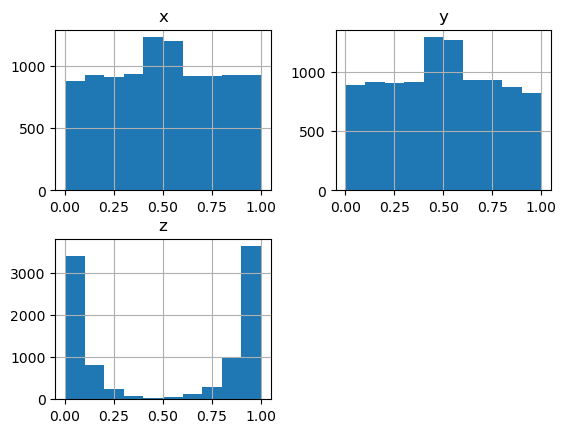

In [32]:
tp.subpx_bias(batch_track)

(array([6.339e+03, 1.320e+02, 1.160e+02, 2.480e+02, 3.100e+02, 2.290e+02,
        1.800e+02, 2.220e+02, 2.340e+02, 2.220e+02, 1.250e+02, 1.860e+02,
        1.260e+02, 9.300e+01, 7.200e+01, 4.100e+01, 6.000e+00, 0.000e+00,
        1.000e+00, 3.000e+00]),
 array([  127516. ,  1245315.3,  2363114.6,  3480913.9,  4598713.2,
         5716512.5,  6834311.8,  7952111.1,  9069910.4, 10187709.7,
        11305509. , 12423308.3, 13541107.6, 14658906.9, 15776706.2,
        16894505.5, 18012304.8, 19130104.1, 20247903.4, 21365702.7,
        22483502. ]),
 <BarContainer object of 20 artists>)

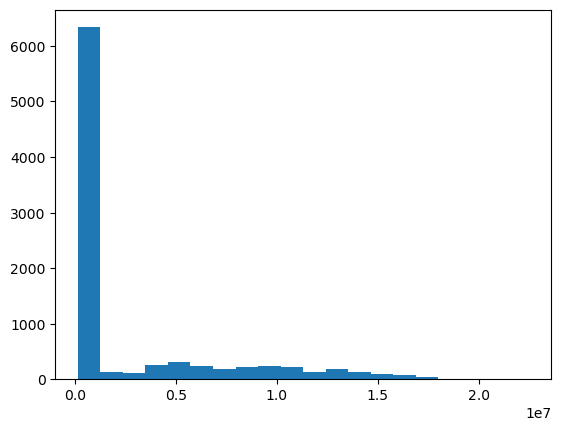

In [33]:
fig,ax=plt.subplots()
ax.hist(batch_track3['raw_mass'], bins=20)

In [34]:
isverbose(batch_track3.columns,vb_chk) #inspecting reworked dataframe with NaN;s removed. Most columns should still be here.

In [35]:
batch_track3['id'] = np.arange(0,len(batch_track3))

C:\Users\Matlab\AppData\Local\Temp\ipykernel_28784\1072258347.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_track3['id'] = np.arange(0,len(batch_track3))


In [36]:
batch_track_reorg=batch_track3[["id","frame","z","y","x"]]

In [37]:
isverbose(batch_track_reorg.head,vb_chk)

# TRACKING

In [38]:
trax = tp.link(batch_track_reorg,search_range=(3,17,17),memory=5) #increasing the range and memory can help produce more positive tracks, especially in the x,y axes where the resolution is quite high. This repersents the radius within which to look for the next hit in the track.

Frame 59: 176 trajectories present.


In [39]:
isverbose(trax.head,vb_chk)

In [41]:
trax_filter=tp.filter_stubs(trax,4)
isverbose(trax_filter.columns,vb_chk)

In [42]:
trax_filter_reorg = trax_filter[['particle','frame','z','y','x']]

In [43]:
viewer.add_tracks(trax_filter_reorg,name='tracks_T')
viewer.layers['tracks_T'].scale=[6,1,1]

# VECTOR GENERATION

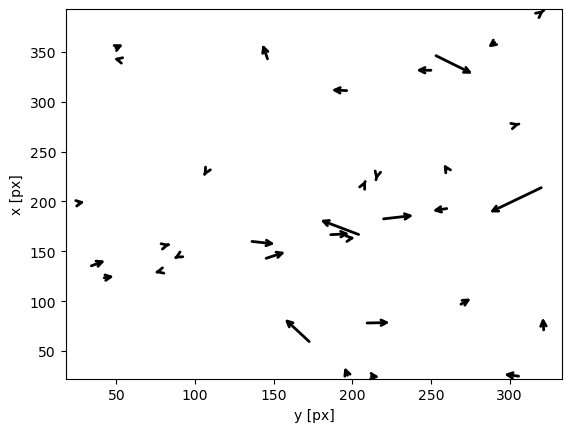

In [44]:
track_vector=tp.plot_displacements(trax_filter,1,10,pos_columns=['y','x'])

In [45]:
#t_filter.to_csv('plot_tracks.csv')
#print(t_filter)
#t_filter[:2]

In [47]:
firstgrouped_tfilter = trax_filter.groupby("particle").first()
isverbose(firstgrouped_tfilter.head,vb_chk)

In [116]:
#firstgrouped_tfilter.to_csv('firstinstance_grouped_tracks.csv') #writing df to csv to inspect how the df is organised. Dev auditing step, not a necessary step for function.

In [48]:
lastgrouped_tfilter = trax_filter.groupby("particle").last()
isverbose(lastgrouped_tfilter.head,vb_chk)

In [49]:
#lastgrouped_tfilter.to_csv('lastinstance_grouped_tracks.csv') #writing df to csv to inspect how the df is organised. Dev auditing step, not a necessary step for function.

In [50]:
#len(lastgrouped_tfilter)
#lastgrouped_tfilter.iloc[3]['z'] #testing iloc in this table

In [51]:
'''
vector_start_solo = np.array([firstgrouped_tfilter.iloc[3]['z'],firstgrouped_tfilter.iloc[3]['y'],firstgrouped_tfilter.iloc[3]['x']])
vector_end_solo = np.array([lastgrouped_tfilter.iloc[3]['z'],lastgrouped_tfilter.iloc[3]['y'],lastgrouped_tfilter.iloc[3]['x']])

#trying vector projection calculation (linear algebra). This isn't what napari means by 'projecting' your vector.
vector_norm_test = np.sqrt(sum(vector_end_solo**2))
vector_projection_test = (np.dot(vector_start_solo,vector_end_solo)/vector_norm_test**2)*vector_end_solo
vector_proj_test = vector_start_solo - vector_projection_test
test_vector=[vector_start_solo,vector_proj_test]
##

vector_dir = vector_end_solo-vector_start_solo
test_vector_dir=[vector_start_solo,vector_dir] #the vector projeection is just the direction vector
test_vector
'''

"\nvector_start_solo = np.array([firstgrouped_tfilter.iloc[3]['z'],firstgrouped_tfilter.iloc[3]['y'],firstgrouped_tfilter.iloc[3]['x']])\nvector_end_solo = np.array([lastgrouped_tfilter.iloc[3]['z'],lastgrouped_tfilter.iloc[3]['y'],lastgrouped_tfilter.iloc[3]['x']])\n\n#trying vector projection calculation (linear algebra). This isn't what napari means by 'projecting' your vector.\nvector_norm_test = np.sqrt(sum(vector_end_solo**2))\nvector_projection_test = (np.dot(vector_start_solo,vector_end_solo)/vector_norm_test**2)*vector_end_solo\nvector_proj_test = vector_start_solo - vector_projection_test\ntest_vector=[vector_start_solo,vector_proj_test]\n##\n\nvector_dir = vector_end_solo-vector_start_solo\ntest_vector_dir=[vector_start_solo,vector_dir] #the vector projeection is just the direction vector\ntest_vector\n"

In [52]:
'''
vectors_layer = viewer.add_vectors(test_vector_dir, edge_width=3,name='test_vector')
viewer.layers['test_vector'].scale=[6,1,1]
'''

"\nvectors_layer = viewer.add_vectors(test_vector_dir, edge_width=3,name='test_vector')\nviewer.layers['test_vector'].scale=[6,1,1]\n"

In [53]:
vector_list=[]
for a in range(0,len(lastgrouped_tfilter)-1):
    vector_start = np.array([firstgrouped_tfilter.iloc[a]['z'],firstgrouped_tfilter.iloc[a]['y'],firstgrouped_tfilter.iloc[a]['x']])
    vector_end = np.array([lastgrouped_tfilter.iloc[a]['z'],lastgrouped_tfilter.iloc[a]['y'],lastgrouped_tfilter.iloc[a]['x']]) #extract start and end point of vector to set up projection calculation
    vector_direction = vector_end - vector_start

    vector_total = [vector_start,vector_direction]
    vector_list.append(vector_total)
    

In [56]:
vector_array=np.asarray(vector_list, dtype=np.float32)
isverbose(vector_array.shape,vb_chk)

In [57]:
isverbose(vector_array[:10],vb_chk)

In [58]:
vectors_layer = viewer.add_vectors(vector_array, edge_width=3,name='vectors_layer')
viewer.layers['vectors_layer'].scale=[6,1,1]

# VECTOR ANGLE CALCULATION

In [169]:
#functions to compare vector angles. compare direction vectors.
def unit_vector(vector):    #Returns the unit vector of the vector  
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2): #Returns the angle in radians between vectors 'v1' and 'v2'

    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

## Manually input points defining start and end of axis. 
start from apex

In [170]:
central_line=viewer.layers['Points'].data

In [171]:
central_line_3d=np.delete(central_line,0,axis=1)


In [172]:
isverbose(central_line,vb_chk)

array([[ 60.        ,   9.        , 177.90539543, 285.78242795],
       [ 60.        ,   9.        , 215.44901069, 134.27663303]])

In [173]:
central_line_dir_vector=central_line_3d[0]-central_line_3d[1] #because I drew the points in 'reverse order' where I draw set the basal point as vector start, I've inverted how I usually calculate my direction vector. That way, we count clockwise from apical point (in this specific image, anyway. Always check thet order in which you lay down the central line points when doing it manually in napari.

In [174]:
#check angle of earlier test vector (direction vector) against drawn in central line (points)

angle_between(central_line_dir_vector,vector_dir)

0.5031094757774348

In [175]:
angles_from_central=[]
for b in range(0,len(vector_array)-1):
    track_vector_angle_dir=vector_array[:,1][b]
    angle_from = angle_between(central_line_dir_vector,track_vector_angle_dir)
    angles_from_central.append(angle_from)

In [111]:
#create dataframe out of angles and export to csv
export_angles_dataframe=pd.DataFrame(angles_from_central,columns=['angles'])
export_angles_dataframe.to_csv('mitosis_vector_angles.csv')

appraising start and end point of random track

In [259]:
points = np.array([vector_start, vector_end])



In [185]:
points_layer = viewer.add_points(points, size=30)

In [186]:
viewer.layers['points'].scale=[6,1,1]

In [272]:
vector_array[:,1][0]

array([0.9133985, 5.305469 , 4.896562 ], dtype=float32)